In [1]:
import pandas as pd
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report


## Wczytanie przykładowych danych (Iris)

In [4]:
iris = load_iris()

X = pd.DataFrame(iris.data, columns=iris.feature_names)  # cechy
y = pd.Series(iris.target, name="target")                # etykieta (klasa)


In [4]:
X.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150 entries, 0 to 149
Data columns (total 4 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   sepal length (cm)  150 non-null    float64
 1   sepal width (cm)   150 non-null    float64
 2   petal length (cm)  150 non-null    float64
 3   petal width (cm)   150 non-null    float64
dtypes: float64(4)
memory usage: 4.8 KB


In [5]:
X.describe()

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm)
count,150.000000,150.000000,150.000000,150.000000
mean,5.843333,3.057333,3.758000,1.199333
std,0.828066,0.435866,1.765298,0.762238
min,4.300000,2.000000,1.000000,0.100000
25%,5.100000,2.800000,1.600000,0.300000
50%,5.800000,3.000000,4.350000,1.300000
75%,6.400000,3.300000,5.100000,1.800000
max,7.900000,4.400000,6.900000,2.500000


In [7]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42
)


In [8]:
model = RandomForestClassifier(
    n_estimators=200,   # liczba drzew
    random_state=42
)

model.fit(X_train, y_train)


,n_estimators,200
,criterion,'gini'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,'sqrt'
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


In [9]:
y_pred = model.predict(X_test)

print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))


Accuracy: 1.0
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        10
           1       1.00      1.00      1.00         9
           2       1.00      1.00      1.00        11

    accuracy                           1.00        30
   macro avg       1.00      1.00      1.00        30
weighted avg       1.00      1.00      1.00        30



## „Nowy zbiór danych” i predykcja

In [10]:
X_new = pd.DataFrame([
    [5.1, 3.5, 1.4, 0.2],
    [6.2, 3.4, 5.4, 2.3],
    [5.9, 3.0, 4.2, 1.5]
], columns=iris.feature_names)

new_pred = model.predict(X_new)
print("Predykcje klas dla nowych danych:", new_pred)

# opcjonalnie: nazwy klas zamiast numerów
class_names = iris.target_names
print("Nazwy klas:", [class_names[i] for i in new_pred])


Predykcje klas dla nowych danych: [0 2 1]
Nazwy klas: [np.str_('setosa'), np.str_('virginica'), np.str_('versicolor')]


In [12]:
proba = model.predict_proba(X_new)
print("Prawdopodobieństwa klas:")
print(proba)



Prawdopodobieństwa klas:
[[1.    0.    0.   ]
 [0.    0.005 0.995]
 [0.    1.    0.   ]]


In [11]:
importance = pd.Series(model.feature_importances_, index=X.columns).sort_values(ascending=False)
print("Ważność cech:")
print(importance)


Ważność cech:
petal length (cm)    0.458036
petal width (cm)     0.408807
sepal length (cm)    0.101960
sepal width (cm)     0.031196
dtype: float64


## Bank Marketing

Cel: przewidzieć czy klient założy lokatę terminową

In [13]:
import pandas as pd

from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split

from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, roc_auc_score


In [14]:
bank = fetch_openml(data_id=1461, as_frame=True)  # bank-marketing
df = bank.frame

df.head()


,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,Class
0,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,261,1,-1,0,unknown,1
1,44,technician,single,secondary,no,29,yes,no,unknown,5,may,151,1,-1,0,unknown,1
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,76,1,-1,0,unknown,1
3,47,blue-collar,married,unknown,no,1506,yes,no,unknown,5,may,92,1,-1,0,unknown,1
4,33,unknown,single,unknown,no,1,no,no,unknown,5,may,198,1,-1,0,unknown,1


In [22]:
print(df.columns)


Index(['V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10', 'V11',
       'V12', 'V13', 'V14', 'V15', 'V16', 'Class'],
      dtype='object')


In [23]:
X_bank = df.drop(columns=["Class"])
y_bank = df["Class"]


In [26]:
X_train_bank, X_test_bank, y_train_bank, y_test_bank = train_test_split(
    X_bank,
    y_bank,
    test_size=0.2,
    random_state=42,
    stratify=y_bank
)


In [35]:
cat_cols_bank = X_bank.select_dtypes(include=["category", "object"]).columns
num_cols_bank = X_bank.select_dtypes(include=["number"]).columns

In [36]:

preprocess_bank = ColumnTransformer(
    transformers=[
        ("cat", OneHotEncoder(handle_unknown="ignore"), cat_cols_bank),
        ("num", "passthrough", num_cols_bank),
    ]
)

pipe_bank = Pipeline(steps=[
    ("prep", preprocess_bank),
    ("rf", RandomForestClassifier(n_estimators=300, random_state=42, n_jobs=-1))
])

pipe_bank.fit(X_train_bank, y_train_bank)

Pipeline(steps=[('prep',
                 ColumnTransformer(transformers=[('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  Index(['V2', 'V3', 'V4', 'V5', 'V7', 'V8', 'V9', 'V11', 'V16'], dtype='object')),
                                                 ('num', 'passthrough',
                                                  Index(['V1', 'V6', 'V10', 'V12', 'V13', 'V14', 'V15'], dtype='object'))])),
                ('rf',
                 RandomForestClassifier(n_estimators=300, n_jobs=-1,
                                        random_state=42))])

In [37]:
new_client_dict = {
    "V1": 10,
    "V2": "A",
    "V3": "B",
    "V4": "C",
    "V5": "A",
    "V6": 3,
    "V7": "B",
    "V8": "C",
    "V9": "A",
    "V10": 7,
    "V11": "B",
    "V12": 2,
    "V13": 5,
    "V14": 1,
    "V15": 9,
    "V16": "C"
}


In [38]:
X_new_bank = pd.DataFrame([new_client_dict])

# ta sama kolejność kolumn
X_new_bank = X_new_bank.reindex(columns=X_bank.columns)

# wymuś identyczne typy jak w treningu (int64 i category)
X_new_bank = X_new_bank.astype(X_bank.dtypes.to_dict())


In [39]:
pred_new = pipe_bank.predict(X_new_bank)[0]
proba_new = pipe_bank.predict_proba(X_new_bank)[0, 1]

print("Predykcja (Class):", pred_new)
print("Prawdopodobieństwo klasy 1:", proba_new)


Predykcja (Class): 1
Prawdopodobieństwo klasy 1: 0.12


In [42]:
rf_model = pipe_bank.named_steps["rf"]


In [43]:
# OneHotEncoder
ohe = pipe_bank.named_steps["prep"].named_transformers_["cat"]

# nazwy cech kategorycznych po OHE
cat_feature_names = ohe.get_feature_names_out(cat_cols_bank)

# cechy numeryczne (bez zmian)
num_feature_names = num_cols_bank.to_numpy()

# wszystkie cechy razem
all_feature_names = list(cat_feature_names) + list(num_feature_names)


In [44]:
import pandas as pd

feature_importance_df = pd.DataFrame({
    "feature": all_feature_names,
    "importance": rf_model.feature_importances_
})

# posortuj malejąco
feature_importance_df = feature_importance_df.sort_values(
    by="importance",
    ascending=False
)


In [45]:
top_features = feature_importance_df.head(15)


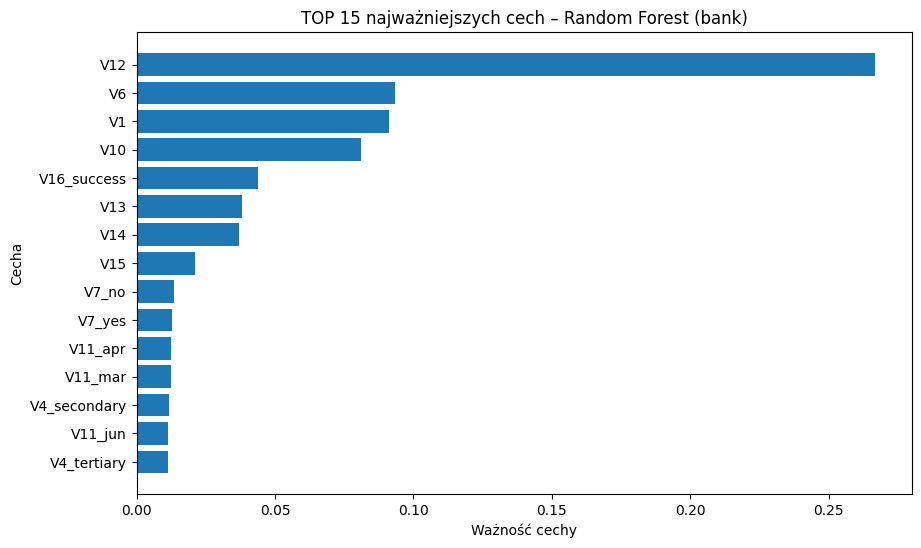

In [46]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.barh(top_features["feature"], top_features["importance"])
plt.xlabel("Ważność cechy")
plt.ylabel("Cecha")
plt.title("TOP 15 najważniejszych cech – Random Forest (bank)")
plt.gca().invert_yaxis()  # najważniejsze na górze
plt.show()
